In [ ]:
#Post the code that you've worked on only if it works! :)

# **Imports**

In [ ]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft
from scipy.stats import pearsonr
from scipy import signal as sig
from scipy.signal import ellip,lfilter,filtfilt,find_peaks
from copy import deepcopy
from scipy import stats
import scipy
import warnings
warnings.filterwarnings('ignore')
from scipy.io import savemat

# **Data**

In [ ]:
fs = 1000 #Hz
train_data = loadmat('raw_training_data.mat')
train_dg = train_data['train_dg']
train_ecog = train_data['train_ecog']

train_dg1 = train_dg[0][0]
train_dg2 = train_dg[1][0]
train_dg3 = train_dg[2][0]

train_ecog1 = train_ecog[0][0]
train_ecog2 = train_ecog[1][0]
train_ecog3 = train_ecog[2][0]

test_data = loadmat('leaderboard_data.mat')['leaderboard_ecog']

sub1_test = test_data[0][0]
sub2_test = test_data[1][0]
sub3_test = test_data[2][0]

time_axis = [i/fs for i in range(300000)]

# **Ashwath**

In [ ]:
from scipy.fft import fft, fftfreq
from scipy.fft import rfft, rfftfreq

def freq_res(filtered_window,fs=1000,dur=0.1):

    n=int(fs*dur)
    yf=rfft(filtered_window,axis=0)
    xf=rfftfreq(n,1/fs)
    ampbin=np.zeros((5))
    ampbin[0]=abs(yf[1]) #8-12
    ampbin[1]=abs(yf[2]) #18-24
    ampbin[2]=abs(yf[7]+yf[8]+yf[9]+yf[10]+yf[11,])/5 #75-115
    ampbin[3]=abs(yf[12]+yf[13]+yf[14]+yf[15:]+yf[16])/5 #125-159
    ampbin[4]=abs(yf[17]) #159-175
    return ampbin

# **Shreya**

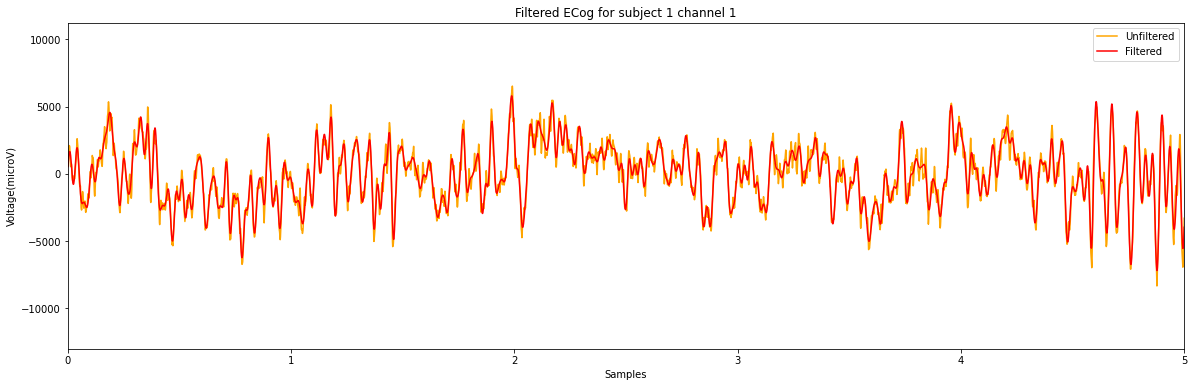

In [ ]:
def filter_data(raw_eeg, fs=1000):
  """
  Write a filter function to clean underlying data.
  Filter type and parameters are up to you. Points will be awarded for reasonable filter type, parameters and application.
  Please note there are many acceptable answers, but make sure you aren't throwing out crucial data or adversly
  distorting the underlying data!

  Input: 
    raw_eeg (samples x channels): the raw signal
    fs: the sampling rate (1000 for this dataset)
  Output: 
    clean_data (samples x channels): the filtered signal
  """
  #SOS-FILTER
  Wn = [60/fs, 200/fs]
  Wn = 2*Wn
  sos = sig.butter(10, 40, btype = 'low', output = 'sos', fs = fs)
  filtered_eeg = sig.sosfiltfilt(sos, np.transpose(raw_eeg))

  return filtered_eeg


filtered_eeg = filter_data(train_ecog1[:,0])

plt.figure(figsize=(20,6))
plt.title("Filtered ECog for subject 1 channel 1")
plt.plot(time_axis, train_ecog1[:,0], c = "orange", label = "Unfiltered")
plt.plot(time_axis, filtered_eeg, c="red", label="Filtered")
plt.xlim([0,5])
plt.xlabel("Samples")
plt.ylabel("Voltage(microV)")
plt.legend()
plt.show()

In [ ]:
def NumWins(x,fs,winLen,winDisp):
  M =np.floor(((len(x)/fs) - winLen + winDisp)/ winDisp)
  return int(M)

def Avg_voltage(x):
  avg_vol = np.mean(x)
  return avg_vol

def Avg_Freq(x, fi, ff): 

  #Convert to frequency domain:
  freq_sig = fft(x)
  N = len(freq_sig)
  n = np.arange(N)
  T = N/fs
  freq = n/T 

  indices = np.where((freq>=fi) & (freq<=ff))[0]
  return np.mean(np.abs(freq_sig[indices]))

In [ ]:
def get_features(filtered_window, fs=1000):
  """
    Write a function that calculates features for a given filtered window. 
    Feel free to use features you have seen before in this class, features that
    have been used in the literature, or design your own!

    Input: 
      filtered_window (window_samples x channels): the window of the filtered ecog signal 
      fs: sampling rate
    Output:
      features (channels x num_features): the features calculated on each channel for the window
  """
  channels = np.shape(filtered_window)[1]
  features = np.empty([channels, 6])
  for ch in range(channels):
    feat1 = Avg_voltage(filtered_window[:,ch])
    feat2 = Avg_Freq(filtered_window[:,ch], 5, 15)
    feat3 = Avg_Freq(filtered_window[:,ch], 20, 25)
    feat4 = Avg_Freq(filtered_window[:,ch], 75, 115)
    feat5 = Avg_Freq(filtered_window[:,ch], 125, 160)
    feat6 = Avg_Freq(filtered_window[:,ch], 160, 175)

    features[ch,:] = [feat1, feat2, feat3, feat4, feat5, feat6]
   
  features = np.reshape(features,(channels*6))

  return features

In [ ]:
def get_windowed_feats(raw_ecog, fs, window_length, window_overlap):
  """
    Write a function which processes data through the steps of filtering and
    feature calculation and returns features. Points will be awarded for completing
    each step appropriately (note that if one of the functions you call within this script
    returns a bad output, you won't be double penalized). Note that you will need
    to run the filter_data and get_features functions within this function. 

    Inputs:
      raw_eeg (samples x channels): the raw signal
      fs: the sampling rate (1000 for this dataset)
      window_length: the window's length
      window_overlap: the window's overlap
    Output: 
      all_feats (num_windows x (channels x features)): the features for each channel for each time window
        note that this is a 2D array. 
  """
  filtered_eeg = np.empty(np.shape(raw_ecog))
  
  for ch in range(np.shape(raw_ecog)[1]):
    filtered_eeg[:,ch] = filter_data(raw_ecog[:,ch])

  M = NumWins(filtered_eeg, fs, window_length, window_overlap)
  xLen = len(filtered_eeg)
  
  L = window_length
  d = window_overlap

  feature_vector = []
  for i in range(int(M)):
    feature_values = get_features(filtered_eeg[int(xLen - ((L+i*d)*fs)) : int(xLen-(i*d*fs)), :])
    feature_vector.append(feature_values)
  feature_vector = np.array(feature_vector)

  return feature_vector

In [ ]:
def create_R_matrix(features, N_wind):
  """ 
  Write a function to calculate the R matrix

  Input:
    features (samples (number of windows in the signal) x channels x features): 
      the features you calculated using get_windowed_feats
    N_wind: number of windows to use in the R matrix

  Output:
    R (samples x (N_wind*channels*features))
  """
  M, ch = np.shape(features)
  feats2 = np.empty([M+N_wind-1, ch])
  
  feats2[N_wind-1:,:] = deepcopy(features)
  for i in range(0,N_wind-1):
    feats2[i, :] = deepcopy(features[i,:])
  
  R = np.empty([M, ch*N_wind + 1])
  R[:,0] = np.ones((M))

  for i in range(2, np.shape(feats2)[0]):
    R[i-2, 1:] = np.concatenate((feats2[i-2,:], feats2[i-1,:], feats2[i,:]), axis=None)

  return R

In [ ]:
def get_windowed_dg(raw_dg, fs, window_length, window_overlap):

  M = NumWins(raw_dg, fs, window_length, window_overlap)
  xLen = len(raw_dg)
  
  L = window_length
  d = window_overlap

  downsampled_dg = np.empty((M, 5))
  for i in range(int(M)):
    for ch in range(5):
      feat = np.mean(raw_dg[int(xLen - ((L+i*d)*fs)) : int(xLen-(i*d*fs)), ch])
      downsampled_dg[i,ch] = feat

  return downsampled_dg

### **Calculating the filter from train data :**

**Sub 1**

In [ ]:
feats1 = get_windowed_feats(train_ecog1, 1000, 0.1,0.05)
feats1 = np.nan_to_num(feats1)

R1 = create_R_matrix(feats1, 3)

Y1 = get_windowed_dg(train_dg1, fs, 0.1, 0.05)  

f1 = np.matmul(np.linalg.inv(np.matmul(np.transpose(R1), R1)),np.matmul(np.transpose(R1), Y1))

**Sub 2**

In [ ]:
feats2 = get_windowed_feats(train_ecog2, 1000, 0.1,0.05)
feats2 = np.nan_to_num(feats2)

R2 = create_R_matrix(feats2, 3)

Y2 = get_windowed_dg(train_dg2, fs, 0.1, 0.05)  

f2 = np.matmul(np.linalg.inv(np.matmul(np.transpose(R2), R2)),np.matmul(np.transpose(R2), Y2))

**Sub 3**

In [ ]:
feats3 = get_windowed_feats(train_ecog3, 1000, 0.1,0.05)
feats3 = np.nan_to_num(feats3)

R3 = create_R_matrix(feats3, 3)

Y3 = get_windowed_dg(train_dg3, fs, 0.1, 0.05)  

f3 = np.matmul(np.linalg.inv(np.matmul(np.transpose(R3), R3)),np.matmul(np.transpose(R3), Y3))

### **Prediction on the test set :**

**Sub 1**

In [ ]:
feats_test1 = get_windowed_feats(sub1_test, 1000, 0.1,0.05)
feats_test1 = np.nan_to_num(feats_test1)

R_test1 = create_R_matrix(feats_test1, 3)

y_hat1 = np.matmul(R_test1,f1) 
y_hat1.shape

(2949, 5)

**Sub 2**

In [ ]:
feats_test2 = get_windowed_feats(sub2_test, 1000, 0.1,0.05)
feats_test2 = np.nan_to_num(feats_test2)

R_test2 = create_R_matrix(feats_test2, 3)

y_hat2 = np.matmul(R_test2,f2) 
y_hat2.shape

(2949, 5)

**Sub 3**

In [ ]:
feats_test3 = get_windowed_feats(sub3_test, 1000, 0.1,0.05)
feats_test3 = np.nan_to_num(feats_test3)

R_test3 = create_R_matrix(feats_test3, 3)

y_hat3 = np.matmul(R_test3,f3) 
y_hat3.shape

(2949, 5)

# **Raima**

## Prediction Interpolation

In [ ]:
from scipy.interpolate import CubicSpline
xs = np.linspace(0, 147.500 , 147500)

Sub 1

In [ ]:
y1 = np.empty_like(y_hat1[:,0]) 
cs1 = [] 
for i in range(y_hat1.shape[1]):
  x1 = np.arange(y_hat1.shape[0])
  y1 = y_hat1[:,i]
  cs1.append(CubicSpline(x1, y1))

In [ ]:
interp_pred1 = np.vstack((cs1[0](xs),cs1[1](xs), cs1[2](xs), cs1[3](xs), cs1[4](xs))).T

(0.0, 100.0)

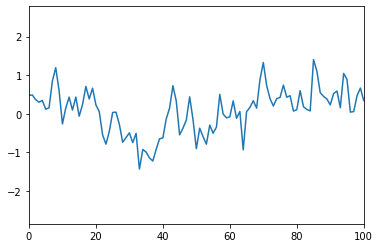

In [ ]:
plt.plot(y_hat1[:,0])
plt.xlim([0,100])

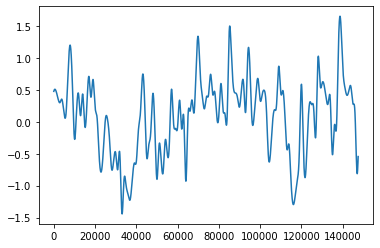

In [ ]:
plt.plot(interp_pred1[:,0])


Sub 2

In [ ]:
y2 = np.empty_like(y_hat2[:,0]) 
cs2 = [] 
for i in range(y_hat2.shape[1]):
  x2 = np.arange(y_hat2.shape[0])
  y2 = y_hat2[:,i]
  cs2.append(CubicSpline(x2, y2))

In [ ]:
interp_pred2 = np.vstack((cs2[0](xs),cs2[1](xs), cs2[2](xs), cs2[3](xs), cs2[4](xs))).T

Sub 3

In [ ]:
y3 = np.empty_like(y_hat3[:,0]) 
cs3 = [] 
for i in range(y_hat3.shape[1]):
  x3 = np.arange(y_hat3.shape[0])
  y3 = y_hat3[:,i]
  cs3.append(CubicSpline(x3, y3))

In [ ]:
interp_pred3 = np.vstack((cs3[0](xs),cs3[1](xs), cs3[2](xs), cs3[3](xs), cs3[4](xs))).T

In [ ]:
predictions = np.zeros((3,1), dtype=object)
predictions[0,0] = interp_pred1
predictions[1,0] = interp_pred2
predictions[2,0] = interp_pred3

In [ ]:
predictions

array([[array([[ 0.47672966, -0.36112898,  0.56132435,  0.73513614,  0.11497552],
               [ 0.47686351, -0.36116882,  0.55906041,  0.73424861,  0.11504832],
               [ 0.47699706, -0.36120776,  0.55680031,  0.73336286,  0.11512085],
               ...,
               [-0.54648044, -0.23551782, -0.26814355, -0.51240746,  0.02336569],
               [-0.54552673, -0.23547223, -0.26846696, -0.5132916 ,  0.02330259],
               [-0.54457224, -0.23542626, -0.26879027, -0.51417534,  0.02323967]])],
       [array([[-0.15111068, -0.40664033, -0.17887744, -0.49616492,  0.88278369],
               [-0.15090441, -0.40696244, -0.17999053, -0.49557863,  0.88315114],
               [-0.15069896, -0.40728405, -0.18110052, -0.49499312,  0.88351786],
               ...,
               [-0.50713259, -0.42230085,  0.99851378,  0.15180002, -0.19774294],
               [-0.50723045, -0.42211443,  0.99898797,  0.15193078, -0.19778675],
               [-0.50732893, -0.42192754,  0.99946162, 

In [ ]:
predictions.shape

(3, 1)

In [ ]:
savemat('predictions.mat', {'predicted_dg':predictions})